<a href="https://colab.research.google.com/github/cris9005/MSDS411-2023/blob/main/411_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import os
import gc
import math
from datetime import datetime

import xgboost
from xgboost import XGBClassifier
import lightgbm as lgb_
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


from imblearn.under_sampling import TomekLinks, RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [3]:
# data wrangling
import pandas as pd# visualization
import matplotlib.pyplot as plt# algorithm
from sklearn.cluster import DBSCAN

In [4]:
traindf=pd.read_csv('/content/assignment-4-option-1-training-2.csv')
traindf.head()

,ID,Prod,Quant,Val,Insp
0,v43,p11,1032.0,4115.0,unkn
1,v44,p11,718.0,4780.0,unkn
2,v45,p11,585.0,3810.0,unkn
3,v46,p11,904.0,7310.0,unkn
4,v42,p11,6989.0,35850.0,unkn


In [5]:
traindf.describe()

,Quant,Val
count,1.292520e+05,1.332150e+05
mean,6.644151e+03,1.257081e+04
std,9.891108e+04,5.556184e+04
min,1.000000e+02,1.005000e+03
25%,1.090000e+02,1.420000e+03
50%,1.850000e+02,2.885000e+03
75%,8.870000e+02,8.730000e+03
max,1.101171e+07,3.913920e+06


In [6]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133731 entries, 0 to 133730
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      133731 non-null  object 
 1   Prod    133731 non-null  object 
 2   Quant   129252 non-null  float64
 3   Val     133215 non-null  float64
 4   Insp    133731 non-null  object 
dtypes: float64(2), object(3)
memory usage: 5.1+ MB


In [6]:
traindf.isnull().sum() #140 Quant missing, 49 val missing

ID          0
Prod        0
Quant    4479
Val       516
Insp        0
dtype: int64

In [7]:
traindf['Quant'].fillna((traindf['Quant'].mean()), inplace=True)


In [8]:
traindf['Val'].fillna((traindf['Val'].mean()), inplace=True)


In [9]:
traindf.groupby(['ID']).mean()

<ipython-input-9-8a36542c345e>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  traindf.groupby(['ID']).mean()


,Quant,Val
ID,,
v1,621.500000,9997.500000
v10,807.034265,6147.600999
v100,63227.333333,124346.666667
v1000,122.857143,3100.000000
v1001,108.333333,1241.666667
...,...,...
v995,1611.777778,20405.000000
v996,561.666667,10006.666667
v997,563.060082,1721.846763


In [10]:
traindf.ID.value_counts().head(15)

v431     2167
v1085    1619
v54      1132
v333      963
v472      807
v1172     795
v426      754
v495      729
v739      724
v1039     647
v1146     646
v1183     610
v397      587
v1149     583
v253      583
Name: ID, dtype: int64

In [11]:
traindf.Prod.value_counts().head(15)

p1125    3524
p3774    1634
p1437    1546
p1917    1527
p4089    1436
p2742    1364
p2273    1256
p2957    1241
p1918    1190
p1215    1184
p4094    1030
p1914    1019
p1910    1008
p1706     993
p2170     964
Name: Prod, dtype: int64

In [12]:
traindf.groupby(['Prod']).mean()

<ipython-input-12-6d9bdf1f3fe5>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  traindf.groupby(['Prod']).mean()


,Quant,Val
Prod,,
p1000,2812.795000,12744.031250
p1001,693.089636,4524.203354
p1002,3683.422222,9645.296296
p1007,415.181818,1858.181818
p1014,1536.328042,7488.015873
...,...,...
p993,5981.701754,27194.853801
p994,3506.484663,23045.398773
p996,2451.145455,8390.681818


In [13]:
testdf=pd.read_csv('/content/assignment-4-option-1-test-2.csv')
testdf.head()

,ID,Prod,Quant,Val,Insp
0,v42,p11,51097.0,310780.0,ok
1,v45,p11,260.0,1925.0,ok
2,v42,p11,51282.0,278770.0,ok
3,v50,p11,46903.0,281485.0,ok
4,v46,p12,475.0,2600.0,ok


In [ ]:
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15732 entries, 0 to 15731
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      15732 non-null  object 
 1   Prod    15732 non-null  object 
 2   Quant   15592 non-null  float64
 3   Val     15683 non-null  float64
 4   Insp    15732 non-null  object 
dtypes: float64(2), object(3)
memory usage: 614.7+ KB


In [15]:
testdf.describe()

,Quant,Val
count,1.559200e+04,1.568300e+04
mean,1.081323e+05,6.333660e+04
std,4.565662e+06,1.758875e+05
min,1.000000e+02,1.005000e+03
25%,1.100000e+02,1.260000e+03
50%,4.460000e+02,1.259500e+04
75%,6.009500e+03,5.590750e+04
max,4.738839e+08,4.642955e+06


In [14]:
testdf.Insp.value_counts()

ok       14462
fraud     1270
Name: Insp, dtype: int64

In [15]:
testdf.isnull().sum() #140 Quant missing, 49 val missing

ID         0
Prod       0
Quant    140
Val       49
Insp       0
dtype: int64

In [16]:
testdf['Quant'].fillna((testdf['Quant'].mean()), inplace=True)


In [17]:
testdf['Val'].fillna((testdf['Val'].mean()), inplace=True)


In [18]:
X= traindf.drop(['Insp','Prod',"ID"], axis=1)
y=traindf['Insp'].values


In [19]:
view1 = testdf.groupby('Insp')['Val'].mean()


In [20]:
labels = traindf.Insp


#K-mean clustering
Clustering methods to detect fraud
The objective of k-means is to minimize the sum of all distances between the data samples and their associated cluster centroids
The score is the inverse of that minimization, so the score should be close to 0.
Using the distance to cluster centroids
Training samples are shown as dots and cluster centroids are shown as crosses
Attempt to cluster the data in image A
Start by putting in an initial guess for two cluster centroids, as in B
Predefine the number of clusters at the start
Then calculate the distances of each sample in the data to the closest centroid
Figure C shows the data split into the two clusters


In [22]:
# Import the packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Transform and scale your data
X = np.array(X).astype(np.float)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define the k-means model and fit to the data
kmeans = KMeans(n_clusters=6, random_state=42).fit(X_scaled)

<ipython-input-22-144e8d849e67>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.array(X).astype(np.float)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

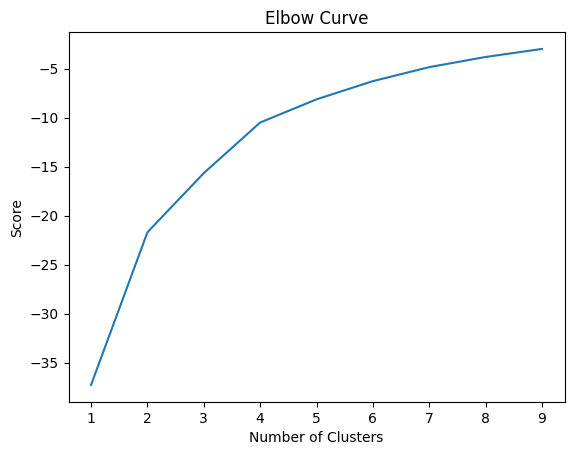

In [23]:
clust = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in clust]

score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

plt.plot(clust,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

The slight elbow at 4 means that 4 clusters could be optimal, but it's not very pronounced


#Scaling the data

For ML algorithms using distance based metrics, it is crucial to always scale your data, as features using different scales will distort your results. K-means uses the Euclidean distance to assess distance to cluster centroids, therefore you first need to scale your data before continuing to implement the algorithm. Let's do that first.
Available is the dataframe df from the previous exercise, with some minor data preparation done so it is ready for you to use with sklearn. The fraud labels are separately stored under labels, you can use those to check the results later.


In [30]:
from sklearn.cluster import MiniBatchKMeans


In [24]:
# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

K-mean clustering
A very commonly used clustering algorithm is K-means clustering. For fraud detection, K-means clustering is straightforward to implement and relatively powerful in predicting suspicious cases. It is a good algorithm to start with when working on fraud detection problems. However, fraud data is oftentimes very large, especially when you are working with transaction data. MiniBatch K-means is an efficient way to implement K-means on a large dataset, which you will use in this exercise.
The scaled data from the previous exercise, X_scaled is available. Let's give it a try.


In [167]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: 

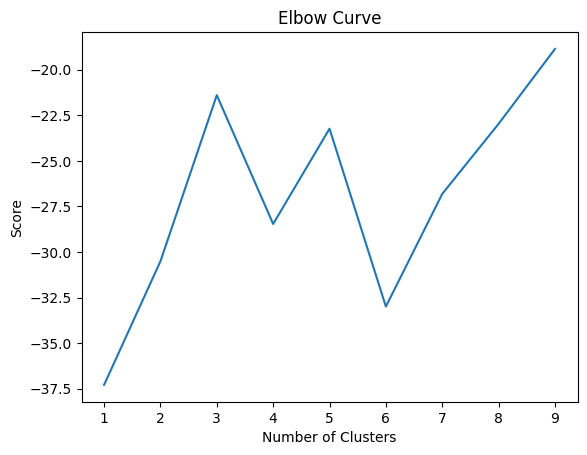

In [168]:
# Plot the models and their respective score
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [169]:
# Define the model
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
kmeans.fit(X_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(random_state=0)

In [170]:
# Run the kmeans model on scaled data
kmeans = KMeans(n_clusters=6, random_state=42).fit(X_scaled)

# Get the cluster number for each datapoint
X_clusters = kmeans.predict(X_scaled)

# Save the cluster centroids
X_clusters_centers = kmeans.cluster_centers_

# Calculate the distance to the cluster centroid for each point
dist = [np.linalg.norm(x-y) for x,y in zip(X_scaled, X_clusters_centers[X_clusters])]

# Create predictions based on distance
km_y_pred = np.array(dist)
km_y_pred[dist>=np.percentile(dist, 93)] = 1
km_y_pred[dist<np.percentile(dist, 93)] = 0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [171]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.3, random_state=0)

# Define K-means model
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [27]:
# Training set and Testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.feature_selection import RFE

In [28]:
testdf['Insp'] = testdf['Insp'].replace('ok', 0)


In [29]:
testdf['Insp'] = testdf['Insp'].replace('fraud',1)

In [30]:
X2 = testdf.drop(['Insp','Prod',"ID"], axis=1)
y2 = testdf["Insp"]


In [33]:
# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled2 = scaler.fit_transform(X2)

In [31]:
X_train2, X_test2, y_train2, y_test2=train_test_split(X_scaled2, y2, test_size=0.3, random_state=np.random.seed(0))


In [178]:
X2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15732 entries, 0 to 15731
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Quant   15732 non-null  float64
 1   Val     15732 non-null  float64
dtypes: float64(2)
memory usage: 245.9 KB


In [179]:


#Define K-means model
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train2)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test2)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test2, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [180]:
# Obtain the ROC score
roc_auc_score(y_test2, km_y_pred)


0.515200946688836

In [190]:
accuracy_score(y_test2, km_y_pred)

0.8811440677966101

In [108]:
from sklearn.metrics import classification_report
target_names = ['0', '1']
print(classification_report(y_test2, km_y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      4335
           1       0.13      0.08      0.10       385

    accuracy                           0.88      4720
   macro avg       0.52      0.52      0.52      4720
weighted avg       0.86      0.88      0.87      4720



#Local Outlier Factor

Algorithm-2A: Local Outlier Factor in Unsupervised Sense

Local Outlier Factor (LOF) finds anomalous data points by measuring the local deviation of a given data point with respect to its neighbouring data points. It has a working principle similar to density based clustering algorithms like DBSCAN etc. Here, I have used it in purely unsupervised sense first (without using labels). Here also, I used a smaller sample of data to avoid longer execution-time

In [31]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, classification_report

In [23]:
from sklearn.ensemble import IsolationForest


In [24]:
from sklearn.neighbors import LocalOutlierFactor

In [25]:
clf_lof = LocalOutlierFactor(n_neighbors=30, algorithm='auto', contamination=.1)
standardized_data_without_class = StandardScaler().fit_transform(X)

In [35]:
y_pred3 = clf_lof.fit_predict(X)
LOF_Scores = clf_lof.negative_outlier_factor_
LOF_pred=pd.Series(y_pred3).replace([-1,1],[1,0])
LOF_anomalies=X_test[LOF_pred==1]

<ipython-input-35-6f89ec224fd8>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  LOF_anomalies=X_test[LOF_pred==1]


In [36]:
# Check if all scores are negative
LOF_Scores

array([-1.02990869, -1.03538912, -1.03474762, ..., -1.        ,
       -1.        , -1.00896134])

In [38]:
y_pred4 = clf_lof.fit_predict(X2)
LOF_pred=pd.Series(y_pred4).replace([-1,1],[1,0])


In [39]:
from sklearn.metrics import classification_report
print(classification_report(y2, LOF_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     14462
           1       0.09      0.11      0.09      1270

    accuracy                           0.84     15732
   macro avg       0.50      0.50      0.50     15732
weighted avg       0.85      0.84      0.84     15732



In [60]:
lofR = pd.crosstab(y2,y_pred3)
maxVal = lofR.idxmax()

In [96]:
from sklearn.preprocessing import LabelBinarizer

# Convert the target to binary.
y2_bin = LabelBinarizer().fit_transform(y2)
f1_score(y2_bin, LOF_pred, average='micro')

0.8362573099415205

In [73]:
maxVal

col_0
-1    0
 1    0
dtype: int64

In [97]:
f1_score(y2, LOF_pred, average='weighted')


0.8441390446072161

#Isolation Forest

In [94]:
model1=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1))
model1.fit(X_train)


IsolationForest(contamination=0.1, n_estimators=50)

In [99]:
random_state = np.random.RandomState(42)
isofor=IsolationForest(n_estimators=100,max_samples='auto',contamination=float(0.2),random_state=random_state)

isofpred =isofor.fit(X2)

print(isofpred.get_params())

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


{'bootstrap': False, 'contamination': 0.2, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': RandomState(MT19937) at 0x7EE705FA4D40, 'verbose': 0, 'warm_start': False}


In [102]:
LF_pred=pd.Series(isofpred).replace([-1,1],[1,0])


<ipython-input-102-f377f5ec1ebe>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  LF_anomalies=X2[LF_pred==1]


IndexingError: ignored

In [82]:
traindf['scores']=model1.decision_function(X)
traindf['anomaly']=model1.predict(X)
traindf.head(20)

,ID,Prod,Quant,Val,Insp,scores,anomaly
0,v43,p11,1032.0,4115.0,unkn,0.070389,1
1,v44,p11,718.0,4780.0,unkn,0.081434,1
2,v45,p11,585.0,3810.0,unkn,0.086159,1
3,v46,p11,904.0,7310.0,unkn,0.060668,1
4,v42,p11,6989.0,35850.0,unkn,-0.074353,-1
5,v47,p11,21135.0,133925.0,unkn,-0.251797,-1
6,v48,p11,22167.0,145225.0,unkn,-0.256094,-1
7,v49,p11,35335.0,214235.0,unkn,-0.302868,-1
8,v49,p11,12206.0,79515.0,unkn,-0.155330,-1
9,v50,p11,1908.0,12795.0,unkn,0.024293,1


Both, Isolation Forest and Local Outlier Factor performed same in predicting Normal cases but Isolation Forest performed far better in detecting Fraud cases. So, Isolation Forest is a clear winner here!!

In [40]:
anomaly=traindf.loc[traindf['anomaly']==-1]
anomaly_index=list(anomaly.index)
print(anomaly)

           ID   Prod    Quant       Val  Insp    scores  anomaly
5         v47    p11  21135.0  133925.0  unkn -0.187843       -1
6         v48    p11  22167.0  145225.0  unkn -0.199401       -1
7         v49    p11  35335.0  214235.0  unkn -0.266193       -1
8         v49    p11  12206.0   79515.0  unkn -0.112000       -1
10        v42    p11  15255.0   99800.0  unkn -0.147734       -1
...       ...    ...      ...       ...   ...       ...      ...
133093   v593  p4088   1917.0   51055.0  unkn -0.045284       -1
133107  v2702  p4088   2443.0   43770.0  unkn -0.022481       -1
133407  v1172  p4093    237.0   76420.0  unkn -0.083907       -1
133584  v3848  p4094   1788.0   79185.0  unkn -0.093465       -1
133621  v2014  p4094    441.0   50740.0  unkn -0.035519       -1

[13357 rows x 7 columns]


In [85]:
def plot_dist(data, color='b', title='Distribution of anomaly score'):
  plt.hist(data, color=color)
  plt.title(title)
  plt.xlabel('Anomaly score')
  plt.ylabel('Count')
  plt.show()

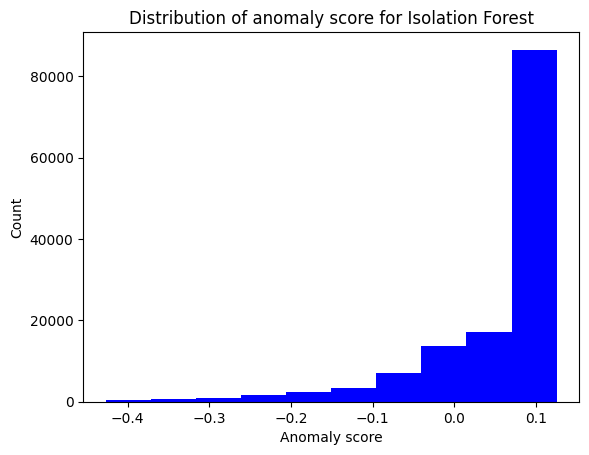

In [110]:

# Plot anomaly score distribution
plot_dist(traindf.scores, color = 'b',
                title = 'Distribution of anomaly score for Isolation Forest')

In [108]:
isopred2 = isofor.predict(X2)
LF_pred2=pd.Series(isopred2).replace([-1,1],[1,0])


In [109]:
from sklearn.metrics import classification_report
print(classification_report(y2, LF_pred2))

              precision    recall  f1-score   support

           0       0.93      0.81      0.86     14462
           1       0.12      0.29      0.17      1270

    accuracy                           0.77     15732
   macro avg       0.52      0.55      0.51     15732
weighted avg       0.86      0.77      0.81     15732



In [ ]:
!pip install pyod


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185329 sha256=cb95c1139c0465e35a19d51b4b2b0ab8ff681c518894d51427df575bb9e461b5
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod


In [114]:
# Obtain the ROC score
roc_auc_score(y2, LF_pred2)


0.5479459610143117

In [115]:
accuracy_score(y2, LF_pred2)

0.7657640478006611

In [116]:
from sklearn.metrics import classification_report
#target_names = ['0', '1']
print(classification_report(y2, LF_pred2))

              precision    recall  f1-score   support

           0       0.93      0.81      0.86     14462
           1       0.12      0.29      0.17      1270

    accuracy                           0.77     15732
   macro avg       0.52      0.55      0.51     15732
weighted avg       0.86      0.77      0.81     15732



# DBSCAN


In [117]:
from sklearn.cluster import DBSCAN
import numpy as np
DBSCAN_cluster1 = DBSCAN(eps=10, min_samples=5).fit(X)

In [117]:

print(type(X), type(y))
X.shape, y.shape

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


((133731, 2), (133731,))

In [ ]:
from sklearn.cluster import DBSCAN
preddb1 = DBSCAN(eps=0.5, min_samples=10).fit(X_scaled)


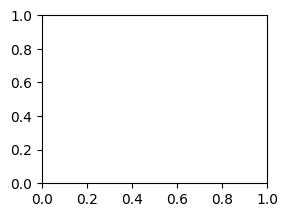

In [41]:
fig = plt.figure()
ax = fig.add_subplot(223)

KeyError: ignored

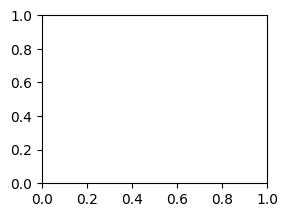

In [42]:
fig = plt.figure()
ax = fig.add_subplot(223)

db = DBSCAN(eps=11, min_samples=6).fit(X)
X['Labels'] = db.labels_
sns.scatterplot(X['Income'], X['Score'], hue=X['Labels'], style=X['Labels'], s=60,
                palette=sns.color_palette('hls', np.unique(db.labels_).shape[0]), ax=ax)
ax.set_title('DBSCAN with epsilon 11, min samples 6')

In [47]:
DBSCAN_cluster1.labels_
# Get the cluster labels (aka numbers)

array([-1, -1, -1, ..., 25,  0,  0])

In [51]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score


In [52]:

# Obtain the predicted labels and calculate number of clusters
pred_labels = DBSCAN_cluster1.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)
# Print performance metrics for DBscan
print(f'Estimated number of clusters: {n_clusters}')
print(f'Homogeneity: {homogeneity_score(labels, pred_labels):0.3f}')
print(f'Silhouette Coefficient: {silhouette_score(X_scaled, pred_labels):0.3f}')

Estimated number of clusters: 1288
Homogeneity: 1.000
Silhouette Coefficient: -0.758


In [ ]:
# Count the total number of clusters
n_clusters_ = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)
# Print model results
print(f'Estimated number of clusters: {n_clusters_}')

# Print model results
print(f'Silhouette Coefficient: {metrics.silhouette_score(X_scaled, pred_labels):0.3f}')


In [160]:
# outliers dataframe
outliers = X[DBSCAN_cluster.labels_ == -1]
print(outliers)

[[ 1032.  4115.]
 [  718.  4780.]
 [  585.  3810.]
 ...
 [  396. 10170.]
 [  632.  4455.]
 [  381.  4695.]]


In [ ]:
# Obtain the ROC score
roc_auc_score(y2, LF_pred2)
